# Wavelet Analysis of Collected Signals

In [1]:
import numpy as np
import matplotlib.a as plt
import matplotlib

In [2]:
import numpy as np
import struct

class ChunkedNPTStackReader:
    def __init__(self, filename, delimiter=','):
        self.filename = filename
        self.file = None
        self.time_len = struct.calcsize('<d')
        self.time_unpack = struct.Struct('<d').unpack_from

    def __enter__(self):
        print("Opening npstack file")
        import io
        if isinstance(self.filename, io.BufferedReader):
          array_file = io.BytesIO()
          array_file.write(self.filename.read())
          array_file.seek(0)
          self.file = array_file
        else:
          self.file = open(self.filename, 'rb')
        return self

    def __iter__(self):
        return self

    def __next__(self):
        if self.file is None:
            raise Exception("Use the context manager interface with this object, i.e. ```with ChunkedNPStackReader('output.csv') as cr: ```")
        try:
            t = self.time_unpack(self.file.read(self.time_len))
            arr = np.load(self.file)
            return t, arr
        except ValueError:
            raise StopIteration()
        except struct.error:
            raise StopIteration()

    def stream(self):
        return np.vstack([arr for arr in self])

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.file.close()


## Get Data

In [3]:
input_file = 'tt2.npts'

In [4]:
with ChunkedNPTStackReader(input_file) as file:
  arr = np.vstack(tuple(a[1] for a in file))
arr.shape, np.max(np.abs(arr)), arr.dtype

Opening npstack file


((28400000, 5), 2000, dtype('int16'))

In [5]:
dt = 1e-6
fs = 1.0 / dt
print(f"dt={dt}\tfs={fs:.0f}Hz")
print(f"Total Time: {arr.shape[0] * dt:.2f}s")

t = np.arange(len(arr)) * dt

dt=1e-06	fs=1000000Hz
Total Time: 28.40s


## Remove AC Noise

In [6]:
import pywt
from scipy.signal import iirfilter, sosfilt, hilbert

In [7]:
data = arr[int(fs * 10): int(fs * 20), 0]
data.shape

(10000000,)

In [8]:
data.mean()

-92.3175487

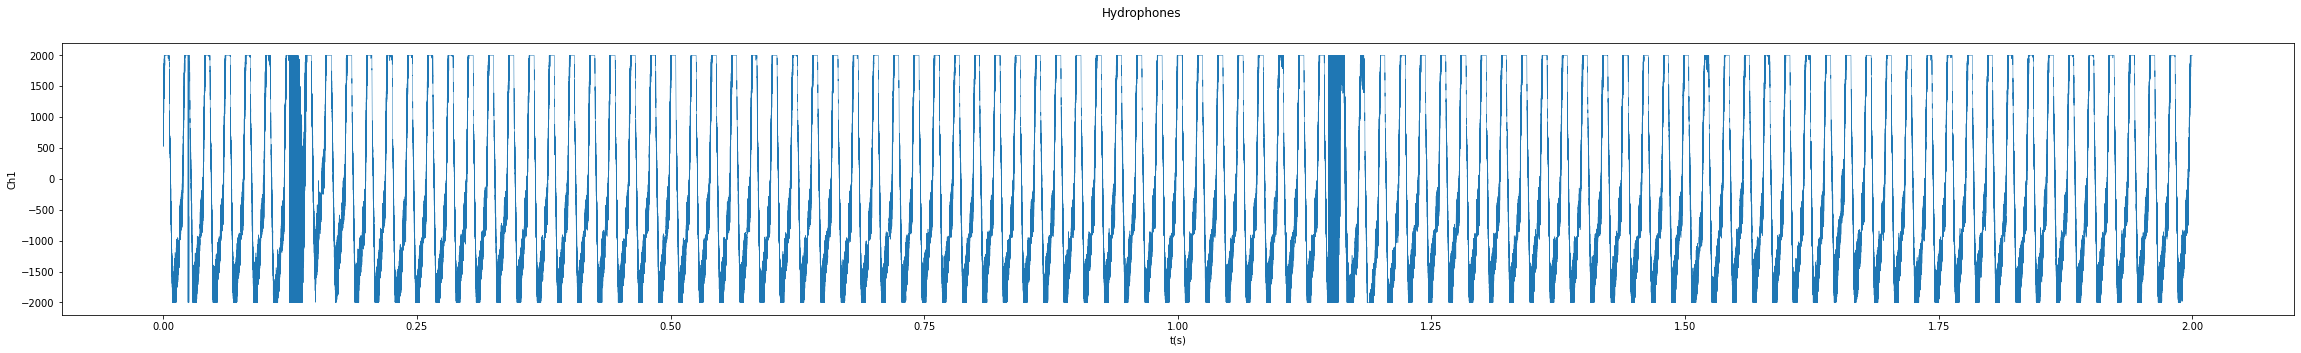

In [9]:
f = plt.figure(figsize=(40,5))
ax = f.gca()
loc = slice(0, data.shape[0] // 5)
ax.plot(t[loc], data[loc],  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hydrophones")
plt.show()

In [10]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
f[-1], f[0]

(50.00000000000001, 50000.00000000001)

In [11]:
coef, freqs=pywt.cwt(data[loc],scale, 'mexh', sampling_period=dt, method='fft')

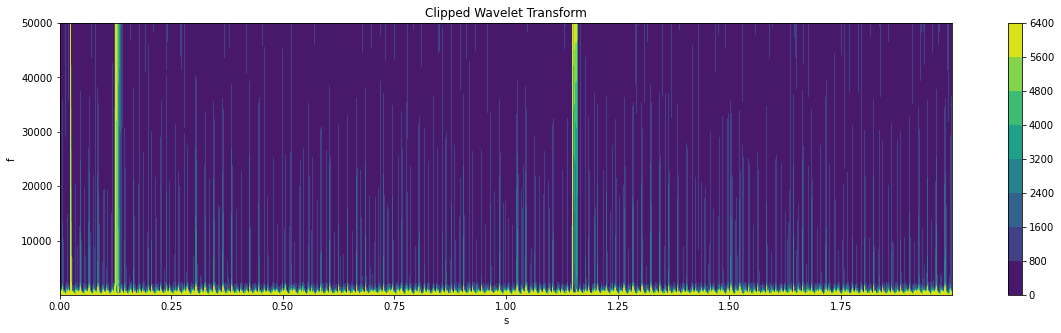

In [12]:
plt.figure(figsize=(20,5))
plt.contourf(t[loc][::500], freqs, np.clip(np.abs(coef[:, ::500]), 0, 6000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()
plt.title('Clipped Wavelet Transform')
plt.show()

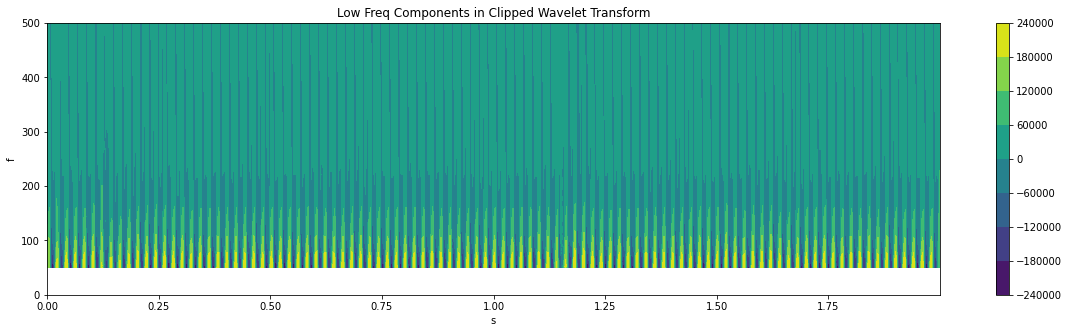

In [13]:
plt.figure(figsize=(20,5))
plt.contourf(t[loc][::500], f, coef[:, ::500])
plt.xlabel('s')
plt.ylabel('f')
plt.ylim(0, 500)
plt.colorbar()
plt.title('Low Freq Components in Clipped Wavelet Transform')
plt.show()

In [14]:
order = 6
pass_freqs = np.array((40e3, 50e3))

lp_data = sosfilt(
    iirfilter(order, pass_freqs / (0.5 * fs), 
              btype='bandpass', ftype='butter', output='sos'), 
    data - data.mean())

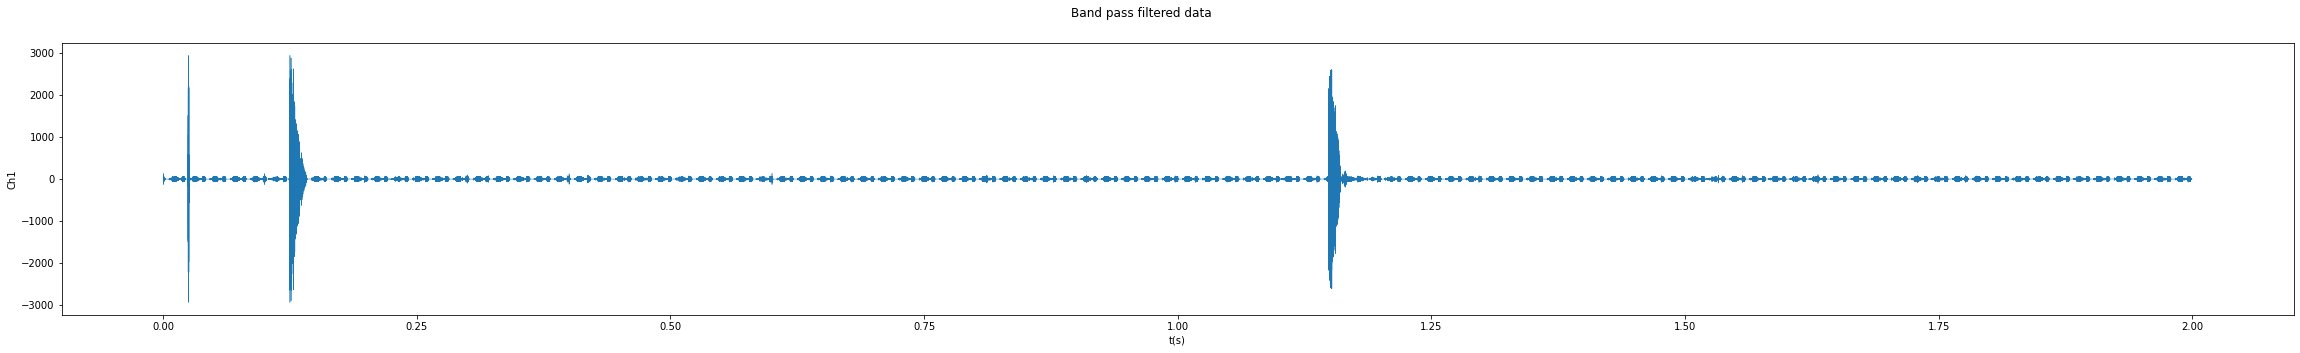

In [15]:
f = plt.figure(figsize=(40,5))
ax = f.gca()
loc = slice(0, data.shape[0] // 5)
ax.plot(t[loc], lp_data[loc],  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Band pass filtered data")
plt.show()

In [16]:
scale = np.linspace(5,5000, 50)
f = pywt.scale2frequency('mexh', scale)/dt
print(f[-1], f[0])
coef, freqs=pywt.cwt(lp_data[loc],scale, 'mexh', sampling_period=dt, method='fft')

50.00000000000001 50000.00000000001


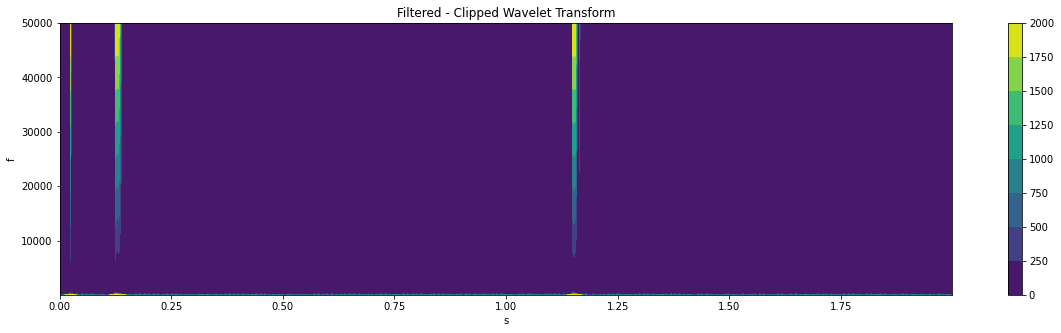

In [17]:
plt.figure(figsize=(20,5))
plt.contourf(t[loc][::500], f, np.clip(np.abs(coef[:, ::500]), 0, 2000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()
plt.title('Filtered - Clipped Wavelet Transform')
plt.show()

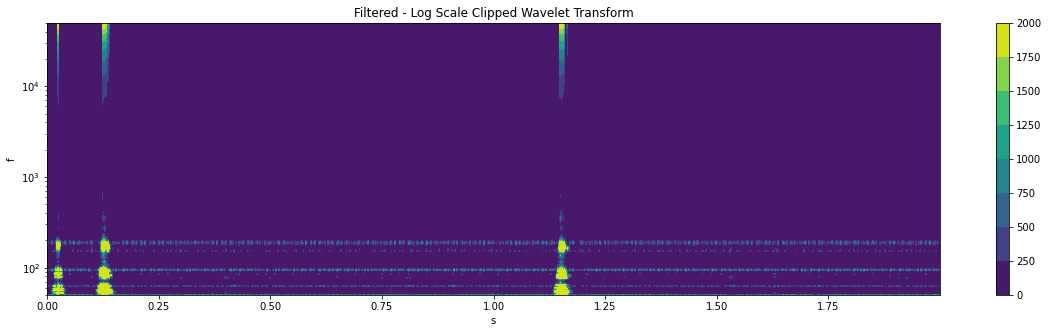

In [18]:
plt.figure(figsize=(20,5))
plt.contourf(t[loc][::500], freqs, np.clip(np.abs(coef[:, ::500]), 0, 2000))
# plt.contourf(t[loc][::500], f, np.clip((coef[:, ::500]), -6000, 6000))
plt.xlabel('s')
plt.ylabel('f')
plt.yscale('log')
plt.colorbar()
plt.title('Filtered - Log Scale Clipped Wavelet Transform')
plt.show()

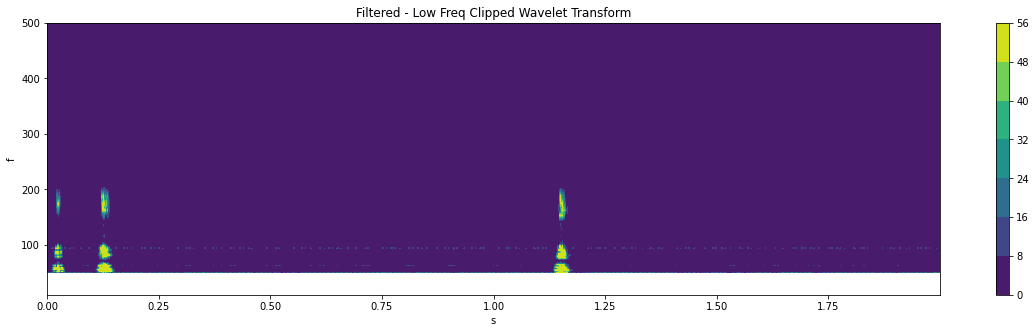

In [19]:
plt.figure(figsize=(20,5))
plt.contourf(t[loc][::500], f, np.clip(np.abs(coef[:, ::500] / freqs[:, None]), 0, 50))
plt.xlabel('s')
plt.ylabel('f')
plt.colorbar()
plt.ylim(10, 500)
plt.title('Filtered - Low Freq Clipped Wavelet Transform')
plt.show()

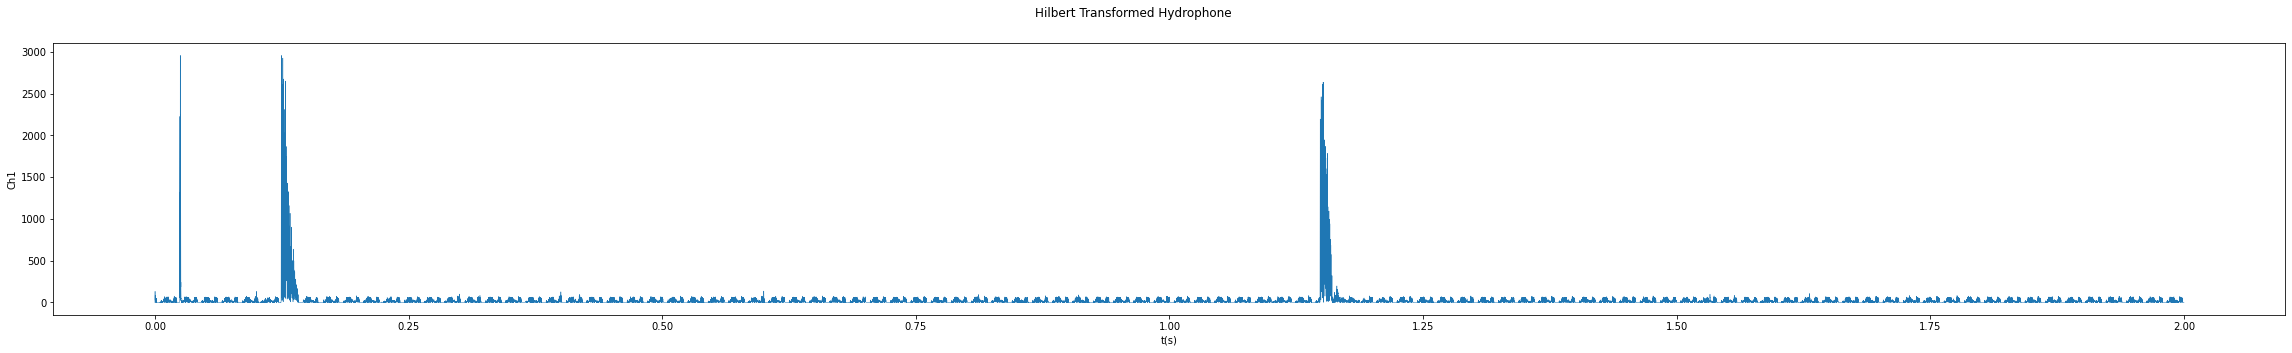

In [20]:
f = plt.figure(figsize=(40,5))
ax = f.gca()
loc = slice(0, data.shape[0] // 5)
ax.plot(t[loc],np.abs(hilbert(lp_data[loc])),  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Hilbert Transformed Hydrophone")
plt.show()

Signal is wide band, hence the hilbert transform wont work.

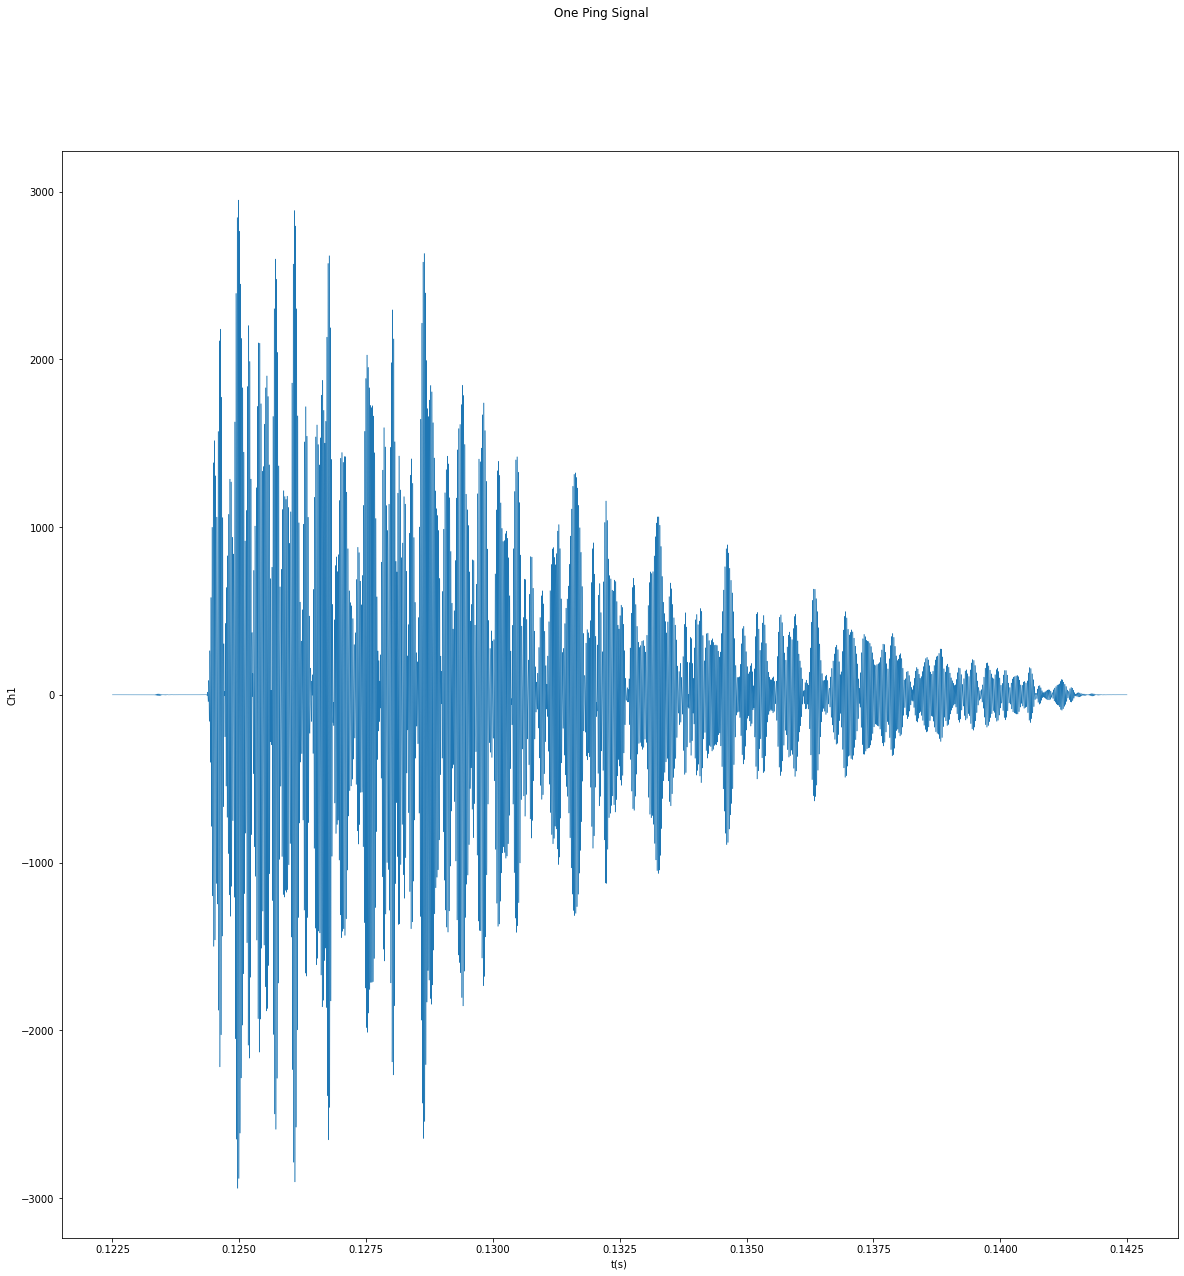

In [21]:
f = plt.figure(figsize=(20,20))
ax = f.gca()
loc = slice(int(fs * 0.1225), int(fs * 0.1425))
ax.plot(t[loc],lp_data[loc],  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("One Ping Signal")
plt.show()

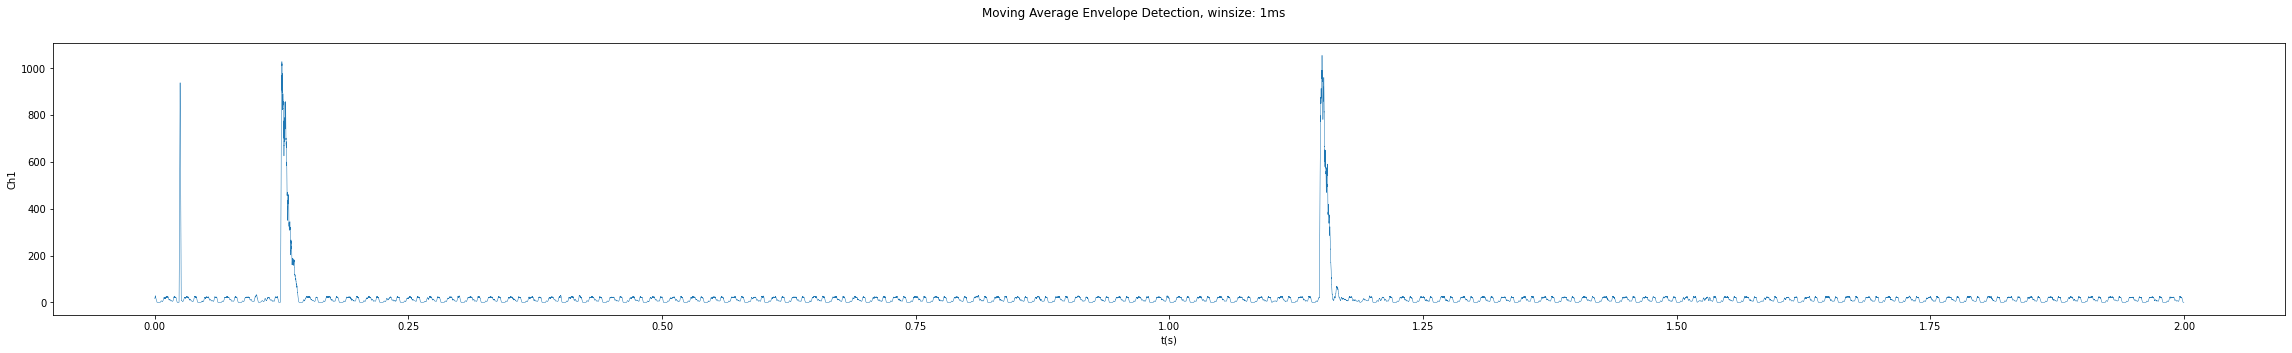

In [22]:
loc = slice(0, data.shape[0] // 5)

w = int(1e-3 * fs)
sig = np.convolve(np.abs(lp_data[loc]), np.ones(w), 'same') / w

f = plt.figure(figsize=(40,5))
ax = f.gca()
ax.plot(t[loc], sig,  linewidth=0.5)
ax.set_ylabel(f"Ch1")
ax.set_xlabel("t(s)")
f.suptitle("Moving Average Envelope Detection, winsize: 1ms")
plt.show()